<a href="https://colab.research.google.com/github/sudeepds/mini-projects/blob/main/Image_Captioning_Using_CNN_and_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question: Image Captioning : Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions. The dataset will be in the form [image → captions]. The dataset consists of input images and their corresponding output captions.




Encoder

The Convolutional Neural Network(CNN) can be thought of as an encoder. The input image is given to CNN to extract the features. The last hidden state of the CNN is connected to the Decoder.

 

Decoder

The Decoder is a Recurrent Neural Network(RNN) which does language modelling up to the word level. The first time step receives the encoded output from the encoder and also the <START> vector.

 

Import Libraries/Dataset (0 mark) 
Import the required libraries
Check the GPU available (recommended- use free GPU provided by Google Colab). 
 

Data Processing(1  mark) 
 

Read the pickle file (https://drive.google.com/file/d/1-JvZrIgH3xVBV--yjiACQXaC-6-vQag8/view?usp=sharing) (Links to an external site.) and convert the data into the correct format which could be used for ML model. 
 Pickle file contains the image id and the text associated with the image.

Eg: '319847657_2c40e14113.jpg#0\tA girl in a purple shirt hold a pillow .

Each image can have multiple captions.

319847657_2c40e14113.jpg -> image name

#0 -> Caption ID

\t  -> separator between Image name and Image Caption

A girl in a purple shirt hold a pillow . -> Image Caption

Corresponding image wrt image name can be found in the image dataset folder.

 

Image dataset Folder : https://drive.google.com/file/d/1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1/view?usp=sharing

 

Plot at least two samples and their captions (use matplotlib/seaborn/any other library). 
Bring the train and test data in the required format. 
 

Model Building (4 mark) 
Use Pretrained Inception model trained on ImageNet dataset (available publicly on google) for image feature extraction.
Create 5 layered GRU layer model and other relevant layers for image caption generation.
Add L2 regularization to all the GRU layers. 
Add one layer of dropout at the appropriate position and give reasons. 
Choose the appropriate activation function for all the layers. 
Print the model summary. 
 

Model Compilation (0.5  mark) 
Compile the model with the appropriate loss function. 
Use an appropriate optimizer. Give reasons for the choice of learning rate and its value. 
Model Training (1 mark) 
Train the model for an appropriate number of epochs. Print the train and validation loss for each epoch. Use the appropriate batch size. 
Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training. 
Model Evaluation (1 mark) 
Take a random image from google and generate caption for that image.
 

Q2) 2.5 Marks

 

Let us define a sequence parity function as a function that takes in a sequence of binary inputs and returns a sequence indicating the number of 1’s in the input so far; specifically, if at time t the 1’s in the input so far is even it returns 1, and 0 if it is odd. For example, given input sequence [0, 1, 0, 1, 1, 0], the parity sequence is [0, 0, 0, 1, 0, 0]. 

 

Implement the minimal vanilla recurrent neural network to learn the parity function. Explain your rationale using a state transition diagram and parameters of the network.

Data Sources
1. A pickle file with the captions. Google Drive path - '/content/drive/MyDrive/Datasets/ImageCaptioningUsingCNN&RNN/set_0.pkl'
2. Images- Flicker Dataset (openly available https://kaggle.com/datasets/hsankesara/flickr-image-dataset)

Code Reference: https://xiangyutang2.github.io/image-captioning/

Architecture Followed

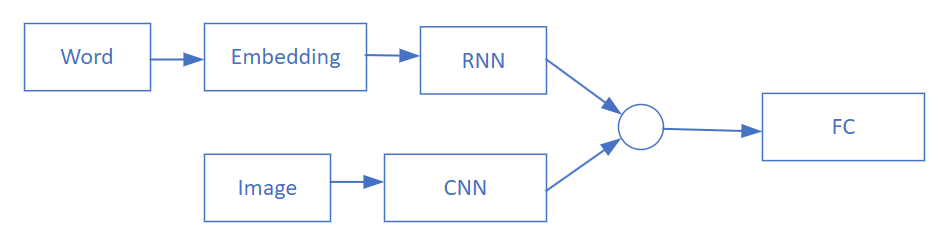


# Group 168

Name               | Registration No
-------------------|------------------
Abhilash S Pillai  | 2020sc04615
Sudeep Ghosh       | 2020sc04781 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [ ]:
from os import listdir
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from pickle import dump
from pickle import load
from keras.preprocessing.text import Tokenizer
from collections import Counter
import keras.utils 
from tensorflow.keras.utils import to_categorical
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from tensorflow.keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

# Question 1 - Image Captioning

In [ ]:
# Reading the given pkl file of captions
image_captions = pd.read_pickle("/content/drive/MyDrive/Datasets/DL Assignment2/set_0.pkl", compression='infer', storage_options=None)

In [ ]:
caption_list = []
for cap in image_captions:
  x=cap.split('\t')
  caption_list.append(x)


In [ ]:
df = pd.DataFrame(caption_list, columns=['Name', 'Caption'])

In [ ]:
df[['Name', 'Caption ID']] = df['Name'].str.split('#', expand=True)

### Cleaning up the caption text

In [ ]:
import nltk
import string
import re

In [ ]:
## adding punctuations in a list of characters to be removed
stop = set()
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
## function to remove punctuations, special characters and changing the text to lower case
def clean_text(text):
  text = re.sub('\W+',' ', text)
  final_text = []
  for i in text.split():
    if i.strip().lower() not in stop:
        word = i.strip().lower()
        final_text.append(word)
  return " ".join(final_text) 

In [ ]:
# removing punctuations and changing the text to lower case
df['Caption'] = df['Caption'].apply(clean_text)

In [ ]:
df['Caption'] = df['Caption'].apply(lambda x: '<START> ' + x + ' <END>')

In [ ]:
df.head()

,Name,Caption,Caption ID
0,318667317_108c402140.jpg,<START> A man in a black hoodie be hold a pape...,4
1,2072574835_febf0c5fb9.jpg,<START> Three race dog be run out of the start...,4
2,3083016677_5782bc337c.jpg,<START> Two motorcycle with two rider each . <...,4
3,95734038_2ab5783da7.jpg,<START> A man on a bike nest to a river . <END>,0
4,241346146_f27759296d.jpg,<START> A football player try tackle another p...,1


In [ ]:
caption_dict = df.groupby('Name')['Caption'].apply(list).to_dict()

In [ ]:
caption_dict.get('318667317_108c402140.jpg')

['<START> A man in a black hoodie be hold a paper sign . <END>',
 '<START> A homeless man carry a sign that say " hungry " . <END>',
 '<START> A bearded man hold a sign . <END>',
 '<START> A man in a black hoodie hold a small sign . <END>']

#### Plotting sample images with the associated captions.

In [ ]:
import random

def show_image_with_caption(imageFileName):
  image = load_img("/content/drive/MyDrive/Datasets/DL Assignment2/Image_captioning_Dataset/Flicker8k_Dataset/"+imageFileName)
  plt.imshow(image)
  print('Associated Captions are:')
  for i in caption_dict.get(imageFileName):
    print(i)

Associated Captions are:
<START> A group of student be walk through a campus . <END>
<START> A group of young person walk with two talk on cellphone . <END>
<START> A group of person walk in a park , while some talk on phone . <END>
Associated Captions are:
<START> A brown dog be play with a white fluffy stuff animal . <END>


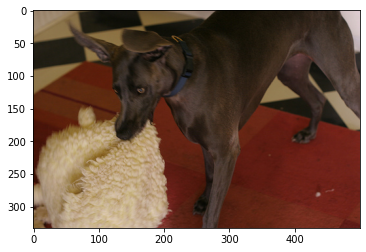

In [ ]:
show_image_with_caption(random.choice(listdir('/content/drive/MyDrive/Datasets/DL Assignment2/Image_captioning_Dataset/Flicker8k_Dataset')))


Associated Captions are:
<START> A girl be wear a blue outfit and hold out her hand to a rainbow . <END>
<START> A young girl bend down to touch a rainbow . <END>
<START> Girl pose with rainbow in the sky . <END>


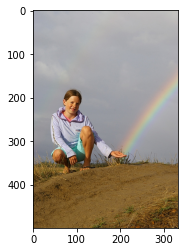

In [ ]:
show_image_with_caption(random.choice(listdir('/content/drive/MyDrive/Datasets/DL Assignment2/Image_captioning_Dataset/Flicker8k_Dataset')))

## Bringing Training and Test Dataset into right format 

In [ ]:
## Utility Function for unzipping a folder
import zipfile
def unzipper(source_path, target_path):
  with zipfile.ZipFile(source_path, 'r') as zip_ref:
      zip_ref.extractall(target_path)

In [ ]:
# Extracting all the image ids from the image Dataset
image_ids = listdir('/content/drive/MyDrive/Datasets/DL Assignment2/Image_captioning_Dataset/Flicker8k_Dataset')

In [ ]:
# Filtering the image ids based on the condition if the corresponding captions are present
cleaned_image_ids=[]
for i in image_ids:
  if i in caption_dict:
    cleaned_image_ids.append(i)

In [ ]:
def list_splitter(list_to_split, ratio):
  left_split = int(len(list_to_split) * ratio)
  return list_to_split[:left_split], list_to_split[left_split:]

### Train test split

In [ ]:
train_image_ids, test_image_ids = list_splitter(cleaned_image_ids, 0.7)

### Building a corpus of words only ftrom Training set leaving out the test set and then tokenizing the built corpus.

In [ ]:
corpus = list()
corpus.extend(['<START>', '<END>', '<UNK>'])

In [ ]:
image_captions_train = dict()
image_captions_test = dict()

for i in train_image_ids : 
  image_captions_train[i]=caption_dict[i]
  for c in caption_dict[i]: corpus.extend(c.split()) 
for i in test_image_ids : 
  image_captions_test[i]=caption_dict[i]
  

In [ ]:
caption_train_tokenizer = Tokenizer() #initialize tokenizer
caption_train_tokenizer.fit_on_texts(corpus) #fit tokenizer on training data

In [ ]:
## Saving all the reusable objects in pickle
fid = open("/content/drive/MyDrive/Datasets/DL Assignment2/image_captions_train.pkl","wb")
dump(image_captions_train, fid)
fid.close()

fid = open("/content/drive/MyDrive/Datasets/DL Assignment2/image_captions_test.pkl","wb")
dump(image_captions_test, fid)
fid.close()

fid = open("/content/drive/MyDrive/Datasets/DL Assignment2/caption_train_tokenizer.pkl","wb")
dump(caption_train_tokenizer, fid)
fid.close()

fid = open("/content/drive/MyDrive/Datasets/DL Assignment2/corpus.pkl","wb")
dump(corpus, fid)
fid.close()

## Extract Image Features
Extracting Image Features from pretrained Inception model and extract its second last layer's output as embedding.
We cannot take the last layer as the pretrained model InceptionV3  is a classification model and we only need the feature weights from it, which is available in the second last layer. 

In [ ]:
base_model = InceptionV3(include_top=True)
base_model.summary()

96124928/96112376 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
from keras.models import Model
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
## Extracting image features from the dataset using the pretrained model and storing onto a dictionary

features = dict()
for file in listdir('/content/drive/MyDrive/Datasets/DL Assignment2/Image_captioning_Dataset/Flicker8k_Dataset'):
    img_path = '/content/drive/MyDrive/Datasets/DL Assignment2/Image_captioning_Dataset/Flicker8k_Dataset/' + file
    img = load_img(img_path, target_size=(299, 299)) #size is 299,299 by default
    x = img_to_array(img) #change to np array
    x = np.expand_dims(x, axis=0) #expand to include batch dim at the beginning
    x = preprocess_input(x) #make input confirm to InceptionV3 input format
    fc2_features = model.predict(x)
    
    name_id = file.split('.')[0] #take the file name and use as id in dict
    features[name_id] = fc2_features

dump(features, open('/content/drive/MyDrive/Datasets/DL Assignment2/features.pkl', 'wb'))

## Using Word Embeddings

We will use pretrained word embeddings from GloVe which is publicly available.

In [ ]:
unzipper('/content/drive/MyDrive/Datasets/DL Assignment2/glove.6B.zip', '/content/drive/MyDrive/Datasets/DL Assignment2/glove.6B')

In [ ]:
embeddings_index = dict()
fid = open('/content/drive/MyDrive/Datasets/DL Assignment2/glove.6B/glove.6B.50d.txt' ,encoding="utf8")
for line in fid:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
fid.close()

In [ ]:
EMBEDDING_DIM = 50 ## As we chose the 50d embeddings from the GloVe
word_index = caption_train_tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, idx in word_index.items():
    embed_vector = embeddings_index.get(word)
    if embed_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[idx] = embed_vector
        
fid = open("/content/drive/MyDrive/Datasets/DL Assignment2/embedding_matrix.pkl","wb")
dump(embedding_matrix, fid)
fid.close()

## Generating Training Data for Progressive Loading

As we are using RNN as the language model to generate words, we need to feed the already generated captions into the model and the get the next word. This means, generating a caption of n words, the model need to be run n+1 times. During training as well we need to run the model n+1 times for each caption. Assuming, there are on average 5 captions per image and 5000 images in the training set and max length of caption 33, the model need to run for 5000 * 5 * 33 times or  825000 times. This would require a lot of resources which is scarce. 

Thus, we will generate training data on the fly, one batch at a time. This is called Progressive Loading. 

In [ ]:
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0] #[0] is used to take out the extra dim. This changes text to a number
        # split one sequence(sentence) into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(np.squeeze(X1)), np.array(X2), np.array(y)

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, batch_size, vocab_size):
    # loop for ever over images
    current_batch_size=0
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            if current_batch_size == 0:
                X1, X2, Y = list(), list(), list()
            
            imageFeature_id = key.split('.')[0]
            photo = photos[imageFeature_id][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            
            X1.extend(in_img)
            X2.extend(in_seq)
            Y.extend(out_word)
            current_batch_size += 1
            if current_batch_size == batch_size:
                current_batch_size = 0
                yield [[np.array(X1), np.array(X2)], np.array(Y)]

In [ ]:
from pickle import load
fid = open('/content/drive/MyDrive/Datasets/DL Assignment2/features.pkl', 'rb')
image_features = load(fid)
fid.close()

In [ ]:
# test the data generator
caption_max_length = 33
batch_size = 1
vocab_size = 4584
generator = data_generator(image_captions_train, image_features, caption_train_tokenizer, caption_max_length, batch_size, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(53, 2048)
(53, 33)
(53, 4584)


## RNN GRU Model Definition

* Five GRU Layers with L2 regulaization(0.01).
* Two Dropot layers one in the feature extractor model and another in the sequence model.
* Using categorical_crossentropy loss function and Rectified Linear Unit activation function. 
* Concatenating output from Language Model(RNN) and Image Feature Model(CNN) into a Dense layer. Both RNN and CNN models have output of 256 dimensions thus the concatenated layer receives an input of 512.

In [ ]:
from keras.layers.merge import concatenate
from keras.layers import GRU
from keras.models import Model
def define_model_concat(vocab_size, max_length, embedding_matrix):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    image_feature = Dropout(0.5)(inputs1)
    image_feature = Dense(256, activation='relu')(image_feature)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    language_feature = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs2)
   
    language_feature = Dropout(0.5)(language_feature)
    language_feature = GRU(256, return_sequences=True, recurrent_regularizer=tf.keras.regularizers.L2(0.01))(language_feature)
    language_feature = GRU(256, return_sequences=True, recurrent_regularizer=tf.keras.regularizers.L2(0.01))(language_feature)
    language_feature = GRU(256, return_sequences=True, recurrent_regularizer=tf.keras.regularizers.L2(0.01))(language_feature)
    language_feature = GRU(256, return_sequences=True, recurrent_regularizer=tf.keras.regularizers.L2(0.01))(language_feature)
    language_feature = GRU(256, recurrent_regularizer=tf.keras.regularizers.L2(0.01))(language_feature)

    # decoder model
    output = concatenate([image_feature, language_feature])
    output = Dense(256, activation='relu')(output)
    output = Dense(vocab_size, activation='softmax')(output)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model_concat.png', show_shapes=True)
    return model

fid = open("/content/drive/MyDrive/Datasets/DL Assignment2/embedding_matrix.pkl","rb")
embedding_matrix = load(fid)
fid.close()

caption_max_length = 33
vocab_size = 4584
post_rnn_model_concat = define_model_concat(vocab_size, caption_max_length, embedding_matrix)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 33)]         0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 33, 50)       229200      ['input_22[0][0]']               
                                                                                                  
 dropout_20 (Dropout)           (None, 33, 50)       0           ['embedding_10[0][0]']           
                                                                                                  
 gru_20 (GRU)                   (None, 33, 256)      236544      ['dropout_20[0][0]']             
                                                                                            

In [ ]:
fid = open("/content/drive/MyDrive/Datasets/DL Assignment2/features.pkl","rb")
image_features = load(fid)
fid.close()

fid = open("/content/drive/MyDrive/Datasets/DL Assignment2/caption_train_tokenizer.pkl","rb")
caption_train_tokenizer = load(fid)
fid.close()

fid = open("/content/drive/MyDrive/Datasets/DL Assignment2/image_captions_train.pkl","rb")
image_captions_train = load(fid)
fid.close()

caption_max_length = 33
vocab_size = 4584

In [ ]:
batch_size = 6
steps = len(image_captions_train)
steps_per_epoch = np.floor(steps/batch_size)

epochs = 3

for i in range(epochs):
	# create the data generator
	generator = data_generator(image_captions_train, image_features, caption_train_tokenizer, caption_max_length, batch_size, vocab_size)
	# fit for one epoch
	post_rnn_model_concat_hist=post_rnn_model_concat.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	post_rnn_model_concat.save('/content/drive/MyDrive/Datasets/DL Assignment2/modelConcat_1_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


3381/5625 [=================>............] - ETA: 48:47 - loss: 2.4245 - acc: 0.4194

# Creating captions using Trained Model

In [ ]:
from keras.models import Model

base_model = InceptionV3(include_top=True)
feature_extract_pred_model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [ ]:
# function to extract features from the given image

def extract_feature(model, file_name):
    img = load_img(file_name, target_size=(299, 299)) #size is 299,299 by default
    x = img_to_array(img) #change to np array
    x = np.expand_dims(x, axis=0) #expand to include batch dim at the beginning
    x = preprocess_input(x) #make input confirm to InceptionV3 input format
    fc2_features = model.predict(x)
    return fc2_features

In [ ]:
# load the tokenizer
caption_train_tokenizer = load(open('/content/drive/MyDrive/Datasets/DL Assignment2/caption_train_tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 33

# load the model
pred_model = load_model('/content/drive/MyDrive/Datasets/DL Assignment2/modelConcat_1_1.h5') 

#### To generate the caption, we first initialize the caption with the "START" token. We then input the caption into the model, which will output the next word in the caption. The generated word will be appended to the end of the caption and fed back into the model. The iterative process stops when the "end" token is received.

In [ ]:
from numpy import argmax

def generate_caption(pred_model, caption_train_tokenizer, photo, max_length):
    in_text = '<START>'
    caption_text = list()
    for i in range(max_length):
            # integer encode input sequence
            sequence = caption_train_tokenizer.texts_to_sequences([in_text])[0]
            # pad input
            sequence = pad_sequences([sequence], maxlen=max_length)
            # predict next word
            model_softMax_output = pred_model.predict([photo,sequence], verbose=0)
            # convert probability to integer
            word_index = argmax(model_softMax_output)
            # map integer to word
            word = caption_train_tokenizer.index_word[word_index]
            #print(word)
            # stop if we cannot map the word
            if word is None:
                break
            # append as input for generating the next word
            in_text += ' ' + word
            # stop if we predict the end of the sequence
            if word != 'end':
                caption_text.append(word)
            if word == 'end':
                break
    return caption_text

### Taking a random image from Google and generating the caption.

a brown dog be run through the grass


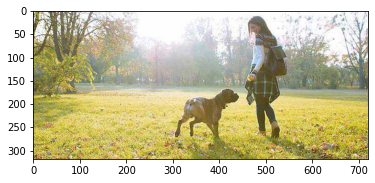

In [ ]:
caption_image_fileName = '/content/drive/MyDrive/Datasets/DL Assignment2/dog-park-etiquette.jpg'
photo = extract_feature(feature_extract_pred_model, caption_image_fileName)
caption = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
print(' '.join(caption))
img = load_img('/content/drive/MyDrive/Datasets/DL Assignment2/dog-park-etiquette.jpg')
plt.imshow(img)

# Q2 Sequence Parity Function

Implementing a minimal vanilla recurrent neural network.

In [ ]:
def parity_fun():
    l=[]
    X=[0, 1, 0, 1, 1, 0]
    Y=[0]*len(X)
    for i in range(len(X)):
      l.append(X[i])
      if l.count(0)%2==0:
        Y[i]=1
      else:
        Y[i]=0
    return X, Y

In [ ]:
a,b=parity_fun()
print('input sequence  ',a)
print('parity sequence  ',b)

input sequence   [0, 1, 0, 1, 1, 0]
parity sequence   [0, 0, 1, 1, 1, 0]


In [ ]:
import torch
from torch import nn
class vanillarnn(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(vanillarnn,self).__init__()
    self.rnn=nn.RNN(input_size,hidden_size,num_layers)
  def forward(self,x):
    return self.rnn(x)
feature_size=2
seq_len=3
batch_size=4
n_layers=1
h_size=5
model=vanillarnn(feature_size,h_size,n_layers)
print(list(model.named_parameters()))
exit()
input=torch.randn(batch_size,seq_len,feature_size)
output,hs=model(input)
print(output)#actual ouput
print(hs)#hidden state

[('rnn.weight_ih_l0', Parameter containing:
tensor([[ 0.4296, -0.1118],
        [ 0.2238,  0.1376],
        [ 0.2447, -0.2253],
        [-0.0697, -0.4273],
        [ 0.4345, -0.1908]], requires_grad=True)), ('rnn.weight_hh_l0', Parameter containing:
tensor([[ 0.1793, -0.1088, -0.1943, -0.4243,  0.3100],
        [-0.1110,  0.1033, -0.3490, -0.2103, -0.2597],
        [ 0.0464,  0.2258, -0.3476,  0.1736,  0.4229],
        [-0.1829, -0.3263,  0.3030, -0.3623, -0.3376],
        [ 0.2823, -0.0925, -0.3442, -0.0653, -0.0261]], requires_grad=True)), ('rnn.bias_ih_l0', Parameter containing:
tensor([-0.1677,  0.4351, -0.1101,  0.1093, -0.0585], requires_grad=True)), ('rnn.bias_hh_l0', Parameter containing:
tensor([ 0.2319, -0.2859, -0.3791, -0.3800,  0.1584], requires_grad=True))]
tensor([[[-0.1124, -0.2856, -0.2917,  0.5051,  0.0600],
         [-0.3321,  0.0590, -0.6772, -0.4496, -0.3478],
         [ 0.4979,  0.4245, -0.2523, -0.4373,  0.5130]],

        [[-0.5669, -0.3512, -0.4837,  0.0491, -0